# SSL Final Report — SimCLR (STL-10)

This notebook is the **final showcase** of the project.

It loads the **strong trained SimCLR run** (`simclr_version_4`) and reproduces:
- training curves (loss)
- quantitative evaluation (kNN / linear probe)
- embedding visualization (UMAP)
- retrieval demo (cosine top-k) + a simple Hit@10 sanity metric

No training is performed here — only loading artifacts and running lightweightanalysis.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import umap

from pathlib import Path
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

from src.data.stl10_datamodule import STL10DataModule
from src.models.simclr import SimCLR
from src.utils.embeddings import (
    load_simclr_from_ckpt,
    infer_encoder_from_simclr,
    compute_embeddings,
    save_embeddings_npz,
    load_embeddings_npz,
)
from src.utils.retrieval import cosine_topk, batch_cosine_topk, mean_class_hit_at_k
from src.utils.seed import set_seed

set_seed(42)

PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
METRICS_DIR   = ARTIFACTS_DIR / "metrics"
LOGS_DIR      = ARTIFACTS_DIR / "logs"
CKPT_DIR      = ARTIFACTS_DIR / "checkpoints"
EMB_DIR       = ARTIFACTS_DIR / "embeddings"
FIG_DIR       = ARTIFACTS_DIR / "figures"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("METRICS_DIR :", METRICS_DIR)
print("LOGS_DIR    :", LOGS_DIR)
print("CKPT_DIR    :", CKPT_DIR)
print("EMB_DIR     :", EMB_DIR)
print("FIG_DIR     :", FIG_DIR)

PROJECT_ROOT: D:\ML\SSL
METRICS_DIR : D:\ML\SSL\artifacts\metrics
LOGS_DIR    : D:\ML\SSL\artifacts\logs
CKPT_DIR    : D:\ML\SSL\artifacts\checkpoints
EMB_DIR     : D:\ML\SSL\artifacts\embeddings
FIG_DIR     : D:\ML\SSL\artifacts\figures


In [16]:
# Select run (strong run)
RUN_ID = "simclr_version_4"

runs_index_path = METRICS_DIR / "runs_index.csv"
summary_path    = METRICS_DIR / "summary.csv"

runs_df = pd.read_csv(runs_index_path)
assert (runs_df["run_id"] == RUN_ID).any(), f"RUN_ID not found in runs_index.csv: {RUN_ID}"

run = runs_df.loc[runs_df["run_id"] == RUN_ID].iloc[0].to_dict()

print("Selected run:")
for k in ["run_id","method","timestamp","version_dir","metrics_csv",
          "ckpt_last","ckpt_best","config_path",
          "seed","max_epochs","batch_size","temperature","lr"]:
    if k in run:
        print(f"  {k:>12}: {run.get(k)}")

version_dir = PROJECT_ROOT / Path(run["version_dir"])
metrics_csv = PROJECT_ROOT / Path(run["metrics_csv"])

ckpt_best = None
if isinstance(run.get("ckpt_best"), str) and run["ckpt_best"].strip():
    ckpt_best = PROJECT_ROOT / Path(run["ckpt_best"])

ckpt_last = None
if isinstance(run.get("ckpt_last"), str) and run["ckpt_last"].strip():
    ckpt_last = PROJECT_ROOT / Path(run["ckpt_last"])

assert metrics_csv.exists(), f"metrics.csv not found: {metrics_csv}"
assert ckpt_best is not None and ckpt_best.exists(), f"best.ckpt not found: {ckpt_best}"

Selected run:
        run_id: simclr_version_4
        method: simclr
     timestamp: nan
   version_dir: artifacts/logs/simclr/version_4
   metrics_csv: artifacts/logs/simclr/version_4/metrics.csv
     ckpt_last: artifacts/checkpoints/simclr/simclr_version_4/last.ckpt
     ckpt_best: artifacts/checkpoints/simclr/simclr_version_4/best.ckpt
   config_path: configs/simclr_r18_stl10_strong.yaml
          seed: 42.0
    max_epochs: 50.0
    batch_size: 128.0
   temperature: 0.2
            lr: 0.001


## Training curves

We plot the training loss logged during SimCLR self-supervised trainin.


## Load metrics.csv + plots

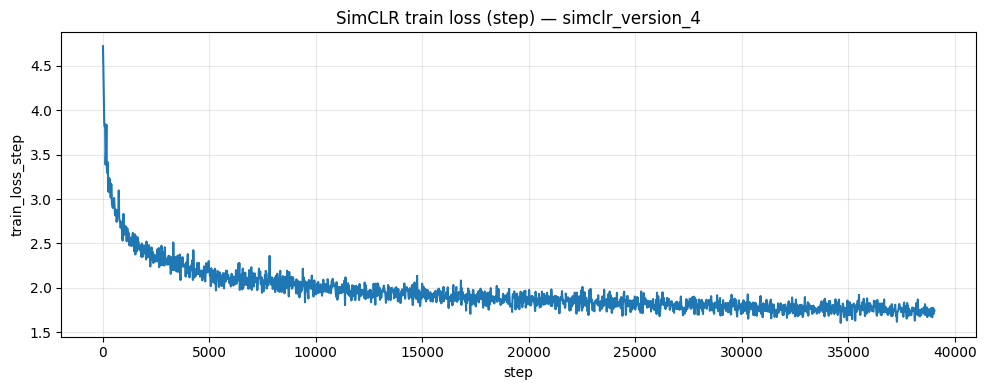

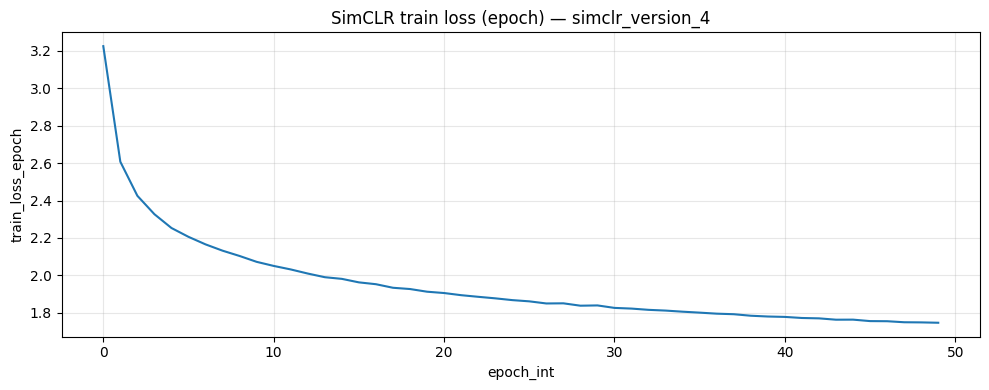

,epoch,lr-AdamW,step,train_loss_epoch,train_loss_step
3949,NaN,0.001,39019,NaN,NaN
3950,49.0,NaN,39019,NaN,1.759907
3951,NaN,0.001,39039,NaN,NaN
3952,49.0,NaN,39039,NaN,1.741604
3953,49.0,NaN,39049,1.74639,NaN


In [17]:
m = pd.read_csv(metrics_csv)

def plot_series(df: pd.DataFrame, x: str, y: str, title: str):
    d = df[[x, y]].dropna()
    if d.empty:
        print(f"Skip: no data for {y}")
        return
    plt.figure(figsize=(10,4))
    plt.plot(d[x].to_numpy(), d[y].to_numpy())
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# step-wise
if "train_loss_step" in m.columns:
    plot_series(m, "step", "train_loss_step", f"SimCLR train loss (step) — {RUN_ID}")

# epoch-wise
if "train_loss_epoch" in m.columns and "epoch" in m.columns:
    me = m.copy()
    me["epoch_int"] = np.floor(me["epoch"].fillna(0)).astype(int)
    plot_series(me, "epoch_int", "train_loss_epoch", f"SimCLR train loss (epoch) — {RUN_ID}")

m.tail(5)

## Quantitative evaluation

We report:
- kNN@20 accuracy (frozen encoder embeddings)
- Linear probe accuracy (frozen encoder + trained linear classifier)

These metrics were computed by evaluation scripts and stored in `artifacts/metrics/summarycsv`.


In [18]:
summary_df = pd.read_csv(summary_path)
assert (summary_df["run_id"] == RUN_ID).any(), f"RUN_ID not found in summary.csv: {RUN_ID}"

row = summary_df.loc[summary_df["run_id"] == RUN_ID].iloc[0]
display(row.to_frame("value"))

print("\nKey results:")
print("  kNN@20 acc    :", row.get("knn_acc"))
print("  Linear acc    :", row.get("linear_acc"))

,value
run_id,simclr_version_4
method,simclr
timestamp,NaN
version_dir,NaN
metrics_csv,NaN
n_rows,NaN
last_epoch,NaN
train_loss_epoch,NaN
train_loss_step,NaN
max_epochs,50.0



Key results:
  kNN@20 acc    : 0.7405
  Linear acc    : 0.7360000610351562


## Embeddings + UMAP

We either:
- load cached embeddings from `artifacts/embeddings/{RUN_ID}_eval_train.npz`, or
- compute them from the best checkpoint if missing.

Then we visualize the embedding space with UMAP (PCA fallback if UMAP is not instaled).


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

emb_path = EMB_DIR / f"{RUN_ID}_eval_train.npz"

if emb_path.exists():
    pack, meta = load_embeddings_npz(emb_path)
    Z = pack.z
    y = pack.y.astype(int)
    print("Loaded embeddings:", Z.shape, "from", emb_path)
else:
    print("Embeddings not found, computing from checkpoint:", ckpt_best)

    dm = STL10DataModule(
        data_dir=str(PROJECT_ROOT / "data"),
        batch_size=256,
        num_workers=4,
        image_size=96,
        pin_memory=True,
    )
    dm.prepare_data()
    dm.setup()

    # load model -> encoder
    simclr = load_simclr_from_ckpt(ckpt_best, device=device, model_cls=SimCLR, strict=True)
    encoder = infer_encoder_from_simclr(simclr).to(device).eval()

    loader = DataLoader(dm.eval_train, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
    pack = compute_embeddings(loader, encoder, device=device, normalize=False)  # normalize later if needed

    Z = pack.z
    y = pack.y.astype(int)

    # save
    EMB_DIR.mkdir(parents=True, exist_ok=True)
    meta = {
        "run_id": RUN_ID,
        "method": "simclr",
        "split": "eval_train",
        "ckpt": str(ckpt_best.relative_to(PROJECT_ROOT)).replace("\\","/"),
        "n": int(Z.shape[0]),
        "dim": int(Z.shape[1]),
    }
    save_embeddings_npz(emb_path, pack, meta)
    print("Saved embeddings to:", emb_path)

Z.shape, y.shape

device: cuda
Loaded embeddings: (5000, 512) from D:\ML\SSL\artifacts\embeddings\simclr_version_4_eval_train.npz


((5000, 512), (5000,))

D:\Anaconda\envs\ssl_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


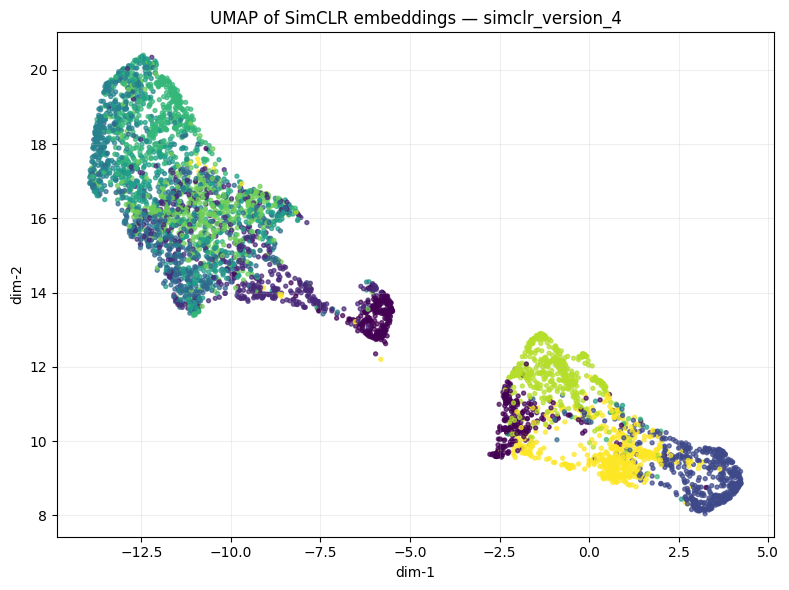

In [20]:
# First reduce with PCA to speed up UMAP
Zp = PCA(n_components=50, random_state=42).fit_transform(Z)

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)
    Z2 = reducer.fit_transform(Zp)
    title = f"UMAP of SimCLR embeddings — {RUN_ID}"

plt.figure(figsize=(8,6))
plt.scatter(Z2[:,0], Z2[:,1], s=8, alpha=0.7, c=y)
plt.title(title)
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [21]:
FIG_DIR.mkdir(parents=True, exist_ok=True)
out = FIG_DIR / f"umap_{RUN_ID}.png"
plt.gcf().savefig(out, dpi=200, bbox_inches="tight")
print("Saved:", out)

Saved: D:\ML\SSL\artifacts\figures\umap_simclr_version_4.png


<Figure size 640x480 with 0 Axes>

## Retrieval demo (cosine top-k)

We demonstrate nearest-neighbor retrieval in the embedding space.
This is a qualitative check that embeddings capture semantic similarity.

We also compute a simple sanity metric: Mean class Hit@10 over random queies.


In [22]:
dm = STL10DataModule(
    data_dir=str(PROJECT_ROOT / "data"),
    batch_size=256,
    num_workers=4,
    image_size=96,
    pin_memory=True,
)
dm.prepare_data()
dm.setup()

ds = dm.eval_train
assert len(ds) == Z.shape[0], "Dataset size and embeddings size mismatch"

len(ds)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


5000

In [23]:
def show_retrieval_grid(ds, res, k=10, title=None):
    idxs = [res.query_index] + res.neighbors[:k].tolist()
    imgs = []
    labels = []
    for i in idxs:
        x, lab = ds[i]
        img = x.permute(1, 2, 0).cpu().numpy()
        imgs.append(img)
        labels.append(int(lab))

    cols = min(k + 1, 6)
    rows = int(np.ceil((k + 1) / cols))

    plt.figure(figsize=(cols * 3, rows * 3))
    for j, (img, lab) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(rows, cols, j + 1)
        ax.imshow(img)
        ax.axis("off")
        if j == 0:
            ax.set_title(f"QUERY\nlabel={lab}", fontsize=10)
        else:
            score = float(res.scores[j - 1])
            ax.set_title(f"#{j}\nlabel={lab}\ncos={score:.3f}", fontsize=9)

    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

## Demo: несколько запросов + Hit@10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.9448375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.716096

Mean class Hit@10 (3 queries sample): 1.0


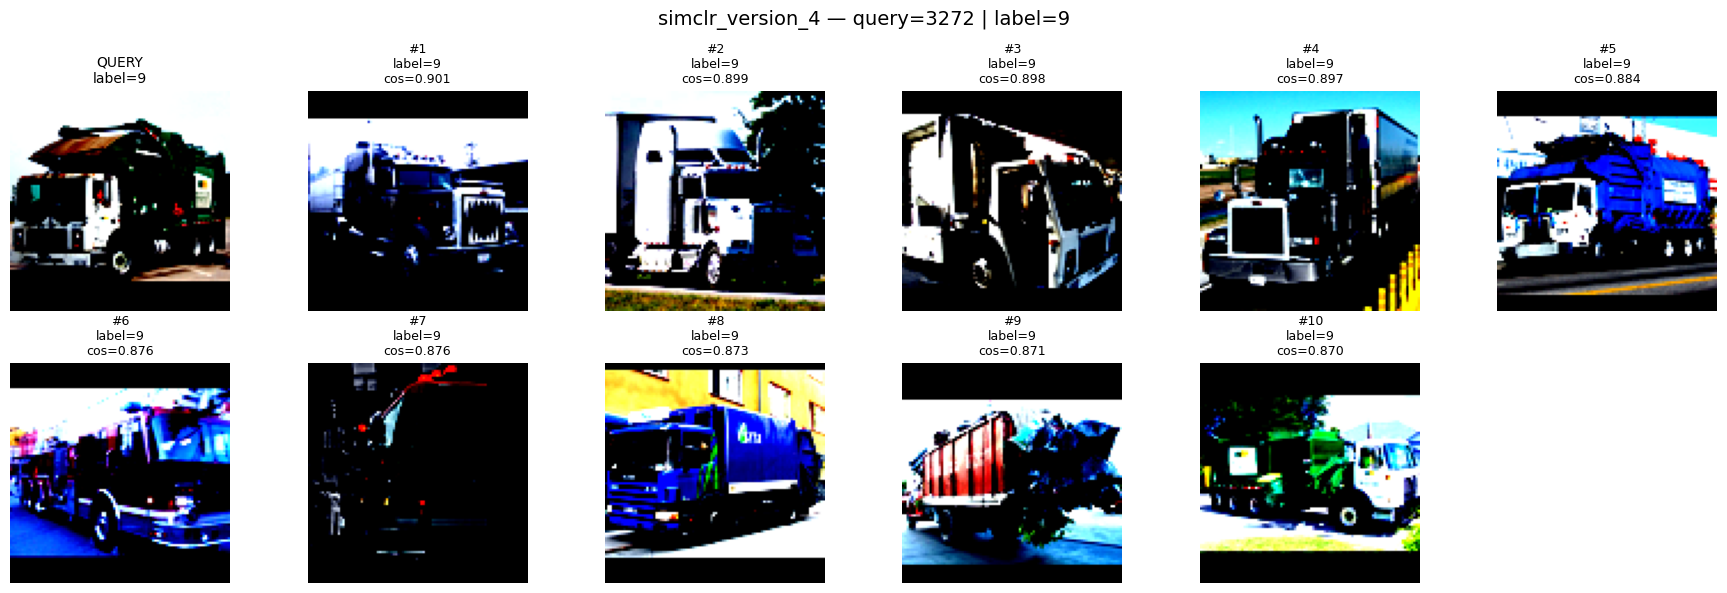

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.0426993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.462739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..1.6668763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968

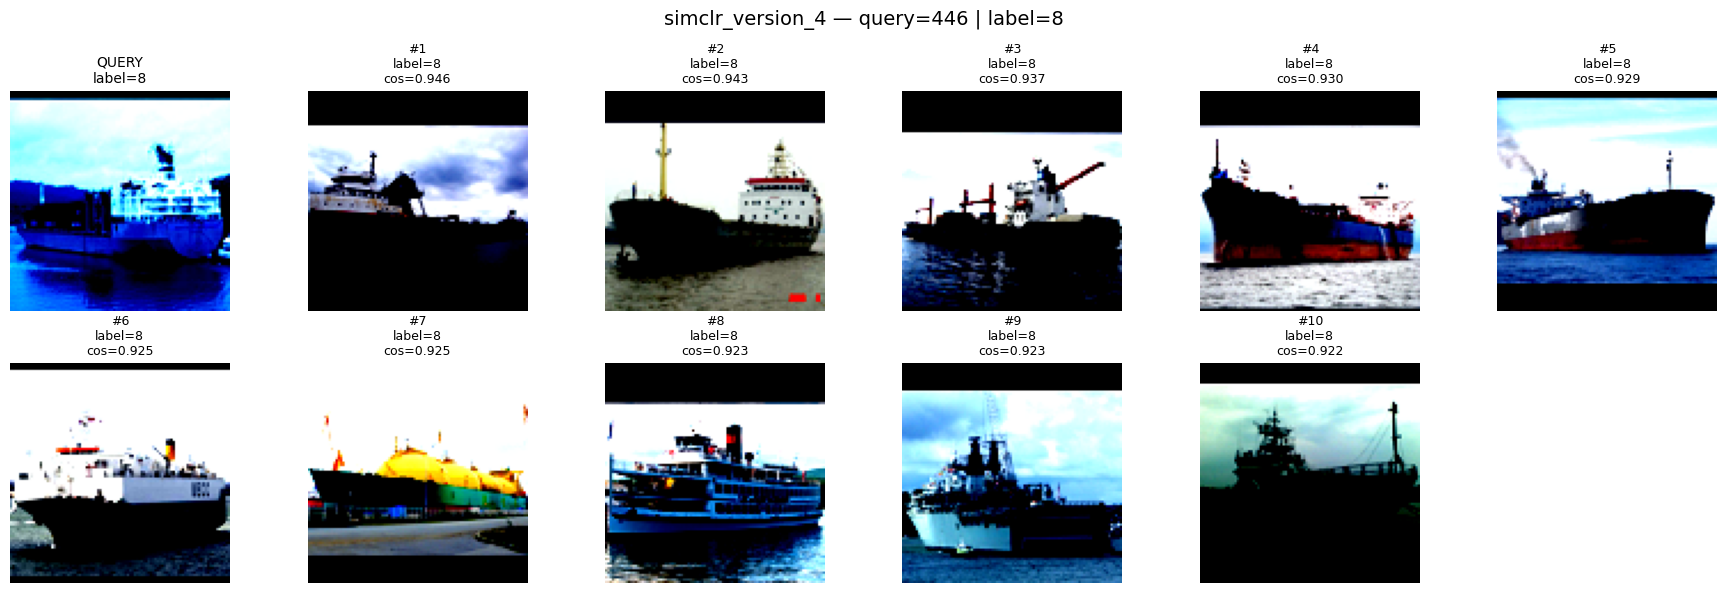

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1872468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7139517..2.1256242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.167882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968..2.1831644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7139517..1.7489849].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7160968

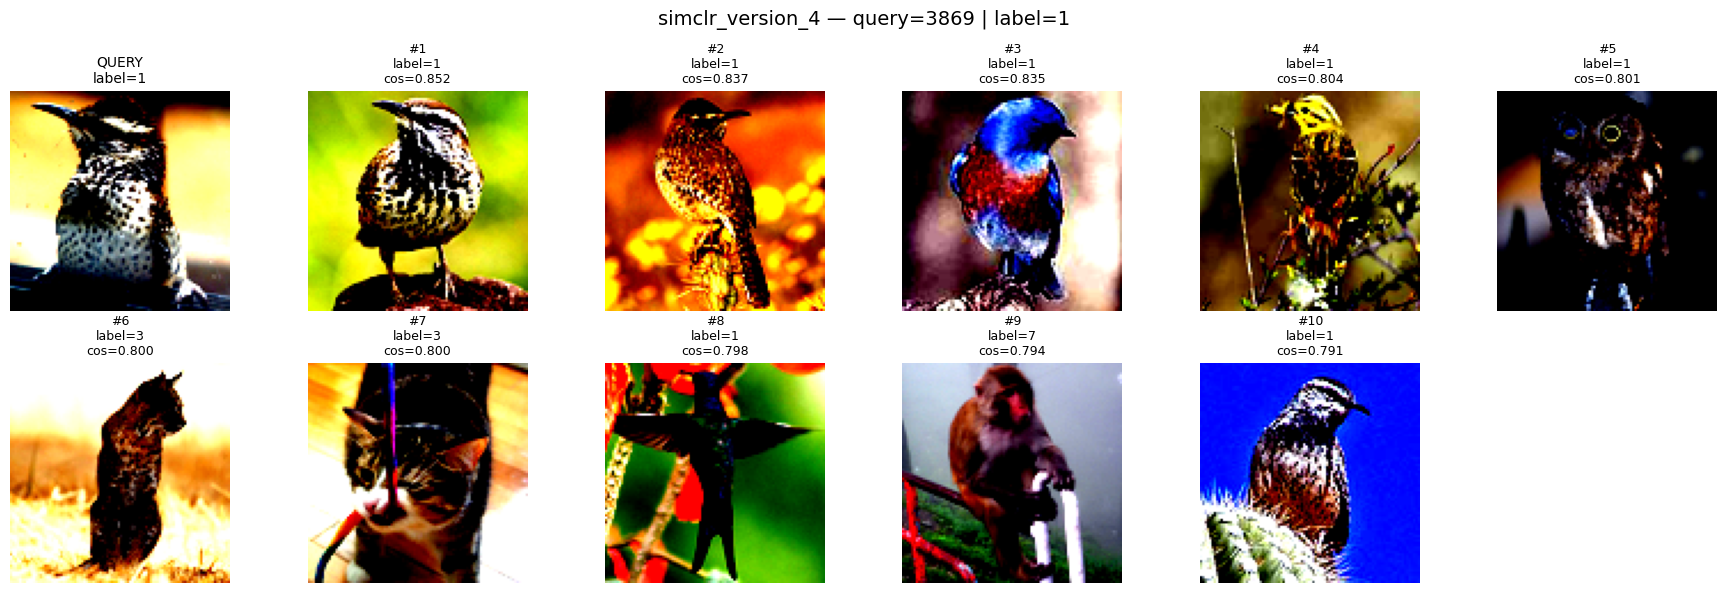

In [24]:
rng = np.random.default_rng(42)
queries = rng.choice(len(ds), size=3, replace=False).tolist()

results = batch_cosine_topk(Z, query_indices=queries, k=10, exclude_self=True, y=y)
hit10 = mean_class_hit_at_k(results, k=10)
print("Mean class Hit@10 (3 queries sample):", hit10)

for qi, r in zip(queries, results):
    show_retrieval_grid(ds, r, k=10, title=f"{RUN_ID} — query={qi} | label={r.query_label}")

In [25]:
rng = np.random.default_rng(123)
queries = rng.choice(len(ds), size=50, replace=False).tolist()
results = batch_cosine_topk(Z, query_indices=queries, k=10, exclude_self=True, y=y)
hit10 = mean_class_hit_at_k(results, k=10)
print("Mean class Hit@10 (50 random queries):", hit10)

Mean class Hit@10 (50 random queries): 0.98


## Final conclusions (SimCLR strong run)

This project demonstrates an end-to-end **Self-Supervised Learning (SSL)** pipeline on **STL-10** using **SimCLR (ResNet-18)**:

### What was done
- Self-supervised pretraining on **STL-10 unlabeled split** (100k images) with SimCLR and NT-Xent loss.
- Full experiment tracking via artifacts:
  - training logs (`metrics.csv`)
  - checkpoints (`best.ckpt`, `last.ckpt`)
  - run registry (`runs_index.csv`) and aggregated results (`summary.csv`)
- Standard evaluation protocols for representation quality:
  - **kNN classification** on the STL-10 test set using frozen embeddings
  - **Linear probe** (frozen encoder + trained linear classifier)
- Qualitative analysis:
  - **UMAP** visualization of learned embeddings
  - simple **nearest-neighbor retrieval** in embedding space + a small Hit@10 sanity check

### Results (run `simclr_version_4`)
- **kNN@20 accuracy:** **0.7405**
- **Linear-probe accuracy (20 epochs):** **0.7360**

### Interpretation
- Both kNN and linear-probe scores indicate that the encoder learned meaningful, transferable features **without labels**.
- The embedding space exhibits noticeable structure (UMAP), and nearest-neighbor retrieval often returns semantically similar samples.

### Notes / Future work
- Add a **BYOL** run (non-contrastive SSL) and compare the same metrics side-by-side.
- Optional engineering upgrade: FAISS indexingfor large-scale retrieval.
